<a href="https://colab.research.google.com/github/veronikafolin/progettoDataIntensive/blob/main/Vehicle_Insurance_Sell_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vehicle Insurance Sell Prediction

Veronika Folin- 
veronika.folin@studio.unibo.it

Progetto di Programmazione di Applicazioni Data Intensive <br>
Corso di Laurea in Ingegneria e Scienze Informatiche <br>
Proff. Gianluca Moro, Roberto Pasolini

Dataset: https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction

## Descrizione del problema e comprensione delle feature

In questo progetto si vuole predire la possibilità che un cliente di una compagnia assicurativa sanitaria possa essere interessato a stipulare un contratto di assicurazione sul veicolo. <br> 
Ciò è estremamente utile per una strategia di comunicazione efficace, volta ad assicurarsi nuova clientela possibilmente fedele.

**Import necessarie**

In [1]:
import os.path
from urllib.request import urlretrieve
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


**Caricamento del dataset**

L'autore del dataset mette a disposizione i dati già suddivisi in train-set e test-set. Utilizzerò solamente il primo dataset per effettuare la K-Fold Cross Validation, in quanto fornisce i dati etichettati.

In [2]:
dataset_url = "https://raw.githubusercontent.com/veronikafolin/progettoDataIntensive/main/datasetProgetto/train.csv"
if not os.path.exists("vehicle-insurance-sell-prediction-train.csv"):
    urlretrieve(dataset_url, "vehicle-insurance-sell-prediction-train.csv")

In [3]:
dataset = pd.read_csv("vehicle-insurance-sell-prediction-train.csv")

In [ ]:
dataset.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Impostiamo l'id del cliente come index del DataFrame

In [ ]:
dataset.set_index("id", inplace=True)
dataset.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Il numero di istanze è uguale a:

In [ ]:
len(dataset)

381109

**Comprensione delle feature**

* ***id*** : codice che identifica univocamente il cliente
* ***Gender*** : genere del cliente
* ***Age*** : età del cliente
* ***Driving_License*** : 1 se il cliente possiede la patente, 0 altrimenti
* ***Regione_Code*** : codice che identifica univocamente la regione del cliente
* ***Previosly_Insured*** : 1 se il cliente è già coperto da un'assicurazione sul veicolo, 0 se non l'ha ancora stipulata
* ***Vehicle_Age*** : età del veicolo
* ***Vehicle_Damage*** : 1 se il cliente ha danneggiato il veicolo in passato, 0 altrimenti
* ***Annual_Premium*** : ammontare del premio assicurativo annuo che il cliente deve pagare
* ***PolicySalesChannel*** : codice anonimizzato che identifica il canale di sensibilizzazione del cliente (es: mail, telefono, di persona... )
* ***Vintage*** : numero di giorni da cui il cliente è associato alla compagnia assicurativa
* ***Response*** : 1 se il cliente è interessato, 0 altrimenti

La variabile da predire *Response* è **binaria**, dobbiamo quindi affrontare un problema di **classificazione**.


## Analisi esplorativa dei dati

### Esplorazione delle singole feature

Il dataset non contiene valori nulli.

In [ ]:
dataset.isna().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

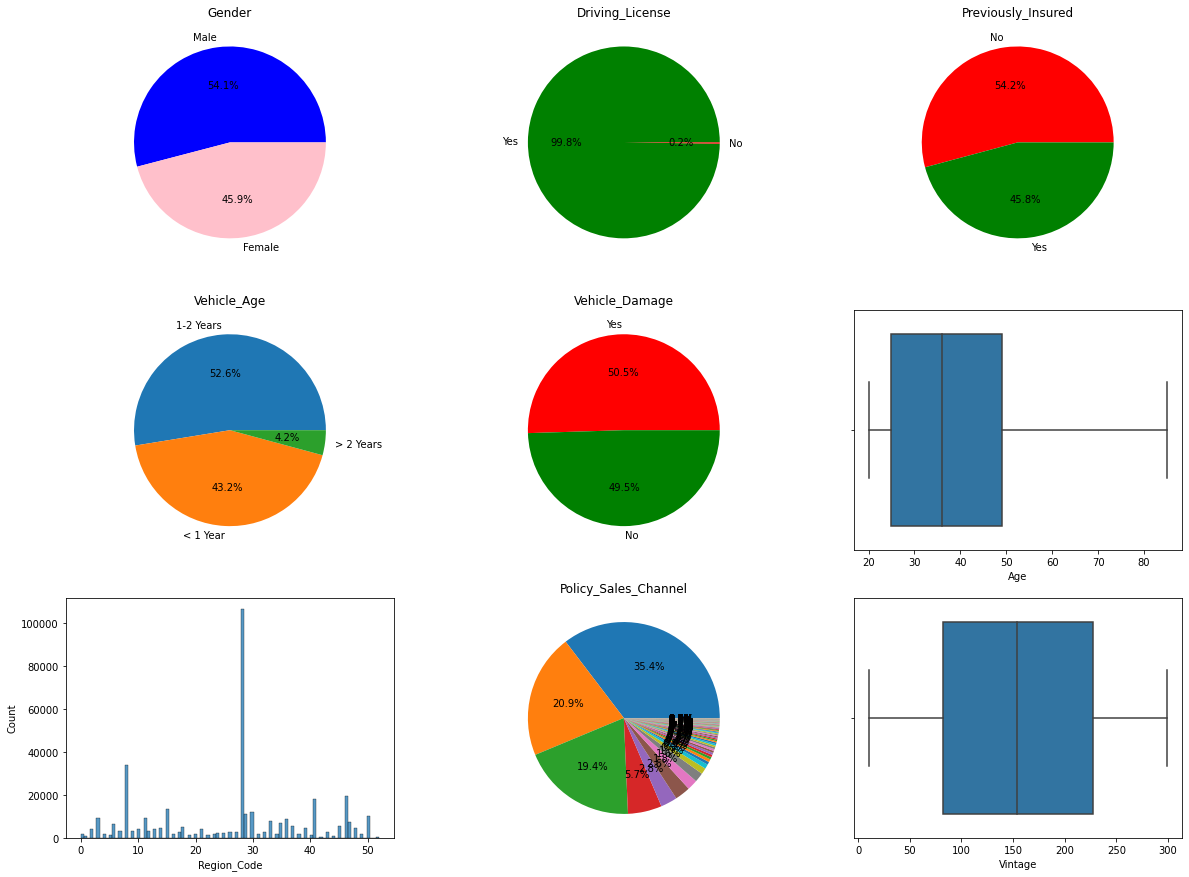

In [ ]:
plt.figure(figsize=(20, 15))

plt.subplot(3, 3, 1)
plt.title('Gender')
plt.pie(dataset['Gender'].value_counts(), autopct="%.1f%%", labels=["Male", "Female"], colors=["blue", "pink"], )

plt.subplot(3, 3, 2)
plt.title('Driving_License')
plt.pie(dataset['Driving_License'].value_counts(), autopct="%.1f%%", labels=["Yes", "No"], colors=["green", "red"])

plt.subplot(3, 3, 3)
plt.title('Previously_Insured')
plt.pie(dataset['Previously_Insured'].value_counts(), autopct="%.1f%%", labels=["No", "Yes"], colors=["red", "green"])

plt.subplot(3, 3, 4)
plt.title('Vehicle_Age')
plt.pie(dataset['Vehicle_Age'].value_counts(), autopct="%.1f%%", labels=["1-2 Years", "< 1 Year", "> 2 Years"])

plt.subplot(3, 3, 5)
plt.title('Vehicle_Damage')
plt.pie(dataset['Vehicle_Damage'].value_counts(), autopct="%.1f%%", labels=["Yes", "No"], colors=["red", "green"])

plt.subplot(3, 3, 6)
sns.boxplot(x="Age", data=dataset)

plt.subplot(3, 3, 7)
sns.histplot(x="Region_Code", data=dataset)

plt.subplot(3, 3, 8)
plt.title('Policy_Sales_Channel')
plt.pie(dataset['Policy_Sales_Channel'].value_counts(), autopct="%.1f%%", )

plt.subplot(3, 3, 9)
sns.boxplot(x="Vintage", data=dataset)

plt.show()

In [ ]:
dataset["Age"].describe()

count    381109.000000
mean         38.822584
std          15.511611
min          20.000000
25%          25.000000
50%          36.000000
75%          49.000000
max          85.000000
Name: Age, dtype: float64

In [ ]:
dataset["Annual_Premium"].describe()

count    381109.000000
mean      30564.389581
std       17213.155057
min        2630.000000
25%       24405.000000
50%       31669.000000
75%       39400.000000
max      540165.000000
Name: Annual_Premium, dtype: float64

In [ ]:
dataset["Vintage"].describe()

count    381109.000000
mean        154.347397
std          83.671304
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

Osserviamo che:
* I clienti sono suddivisi pressochè in maniera equa in base al genere.
* La quasi totalità dei clienti possiede la patente.
* Poco più della metà della clientela non ha ancora stipulato un'assicurazione sul veicolo.
* La maggior parte dei veicoli non ha più di 2 anni di "anzianità".
* La metà dei veicoli ha subito almeno un danno nel passato.
* L'età media dei clienti è circa 39 anni; il più giovane ha 20 anni; il più vecchio ha 85 anni. Il 75% dei clienti ha meno di 49 anni.
* La maggior parte dei clienti si trova in una certa regione.
* Mediamente un premio assicurativo annuo ammonta a 30,564 dollari. Il 75% dei clienti paga fino a 40,000 dollari. 
* I canali di vendita principali sono 3.
* In media i clienti sono assicurati dalla compagnia da poco più di 5 mesi, al massimo da 10 mesi.

**Variabile target**

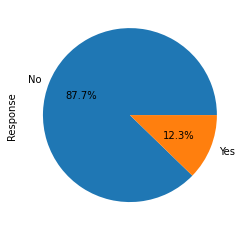

In [ ]:
dataset['Response'].value_counts().plot.pie(autopct="%.1f%%", labels=["No", "Yes"])

* La percentuale di clienti interessati a stipulare un'assicurazione con la compagnia non è particolarmente alta, le classi da predire risultano **sbilanciate**, applicheremo quindi un'operazione di undersampling sulla classe più "popolata" in quanto il dataset è già molto corposo di per sè.

### Esplorazione dei legami fra le feature

Per iniziare produciamo una matrice di correlazione delle feature:

In [ ]:
def plot_correlation(dataset):
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Generate a mask for the upper triangle
    mask = np.zeros_like(dataset, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(dataset, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True, square=True, linewidths=.5, cbar_kws={"shrink": .5});

    # credits: https://colab.research.google.com/github/nicolasfara/di-project/blob/master/cardiovascular-disease.ipynb#scrollTo=LZMJGA-ziDQj

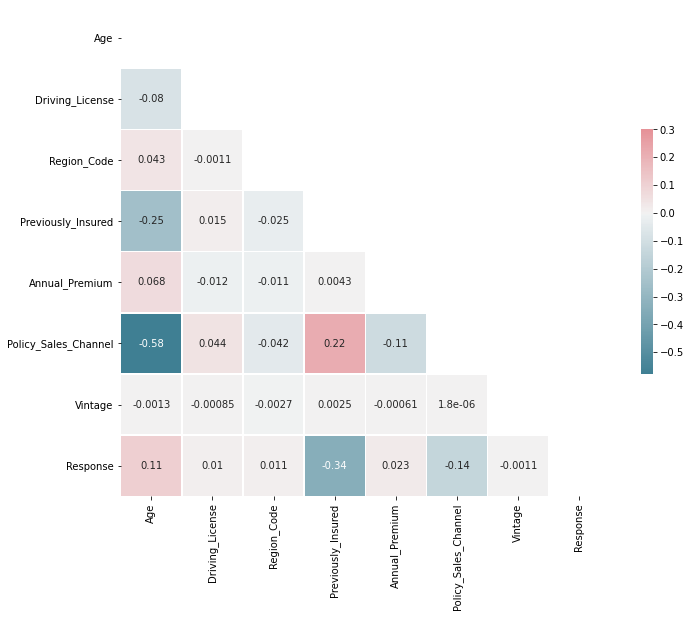

In [ ]:
plot_correlation(dataset.corr())

Nelle prossime celle visualizziamo in dettaglio le correlazioni (e non correlazioni) più rilevanti.

Per visualizzare graficamente come è distribuita la variabile target rispetto al premio assicurativo annuo, ho deciso di considerare i soli clienti che pagano fino a 40.000 dollari ovvero coloro che rientrano nei primi 3 quartili. Questa operazione mi semplifica la visualizzazione perchè non considero gli "outliers".

In [ ]:
dataset_m = dataset[dataset.Annual_Premium <= 40000]

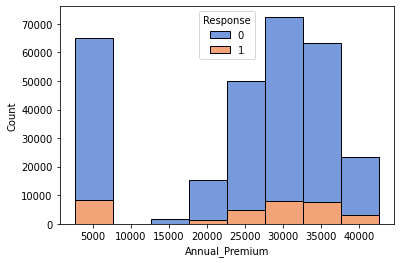

In [ ]:
sns.histplot(x='Annual_Premium', hue='Response', data=dataset_m, palette="muted", multiple="stack", binwidth=5000);

Sembra che l'ammontare del premio assicurativo non influenzi in maniera eclatante l'adesione o meno dei clienti.

Inoltre, come possiamo notare dal prossimo grafico, l'ammontare del premio non è legato all'età.

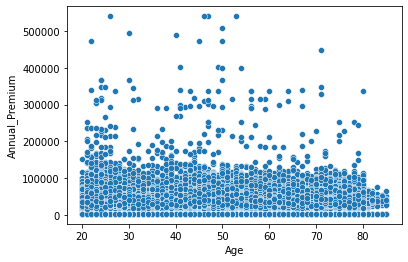

In [ ]:
sns.scatterplot(x="Age", y="Annual_Premium", data=dataset)

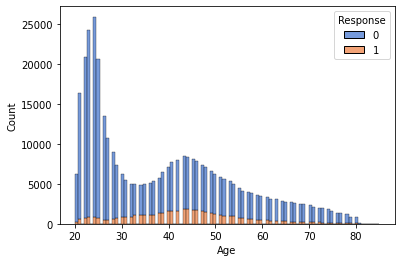

In [ ]:
sns.histplot(x='Age', hue='Response', data=dataset, palette="muted", multiple="stack");

Però sembra che i clienti tra i 40 e i 50 anni siano, in percentuale, i più interessati a stipulare un nuovo contratto di assicurazione sul veicolo.

Come vediamo dal prossimo grafico, in quella fascia d'età abbiamo una percentuale minore di clienti che sono già assicurati.

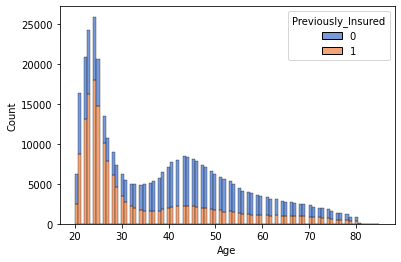

In [ ]:
sns.histplot(x='Age', hue='Previously_Insured', data=dataset, palette="muted", multiple="stack");

Verifichiamo che maschi e femmine sono interessati indistintamente a stipulare un nuovo contratto.

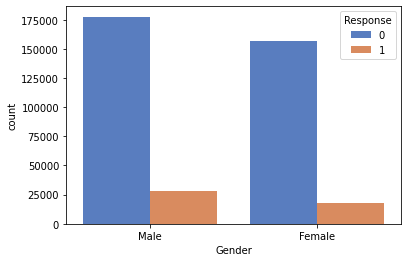

In [ ]:
sns.countplot(x='Gender', hue='Response', data=dataset, palette="muted");

La maggior parte dei clienti vuole stipulare una nuova assicurazione perchè non ne ha ancora una.

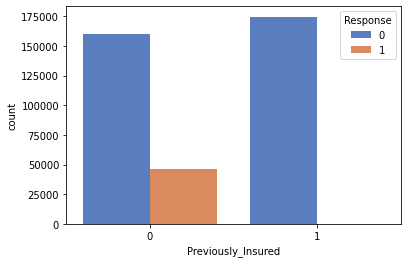

In [ ]:
sns.countplot(x='Previously_Insured', hue='Response', data=dataset, palette="muted");

Successivamente notiamo che i clienti che hanno avuto già un danneggiamento al veicolo in passato, sono più propensi ad aderire.

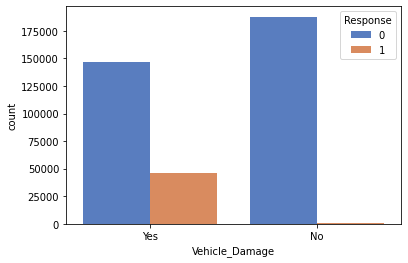

In [ ]:
sns.countplot(x='Vehicle_Damage', hue='Response', data=dataset, palette="muted")

Dai prossimi grafici possiamo capire che i clienti proprietari dei veicoli più vecchi di 1 anno sono più interessati a stipulare un'assicurazione probabilmente perchè hanno effettuato un incidente in passato e non hanno ancora un'assicurazione sul veicolo.

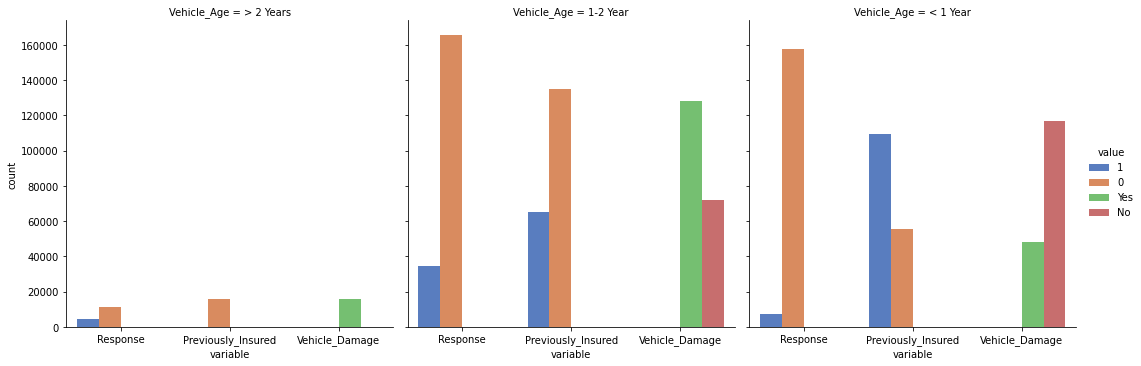

In [ ]:
g = pd.melt(dataset, id_vars=['Vehicle_Age'], value_vars=['Response', 'Previously_Insured', 'Vehicle_Damage'])
sns.catplot(x="variable", hue="value", col="Vehicle_Age", data=g, kind="count", palette="muted");

Osservando il prossimo grafico possiamo dire che la feature "Vintage", ovvero il numero di giorni che la persona è cliente della compagnia, non influenza l'adesione.

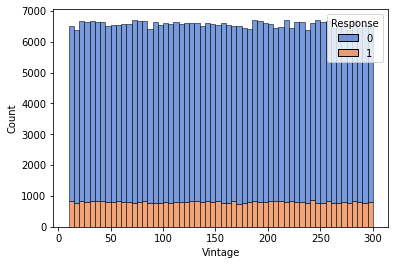

In [ ]:
sns.histplot(x='Vintage', hue='Response', data=dataset, palette="muted", multiple="stack", binwidth=5);

Osserviamo inoltre che la provenienza dei clienti non influenza.

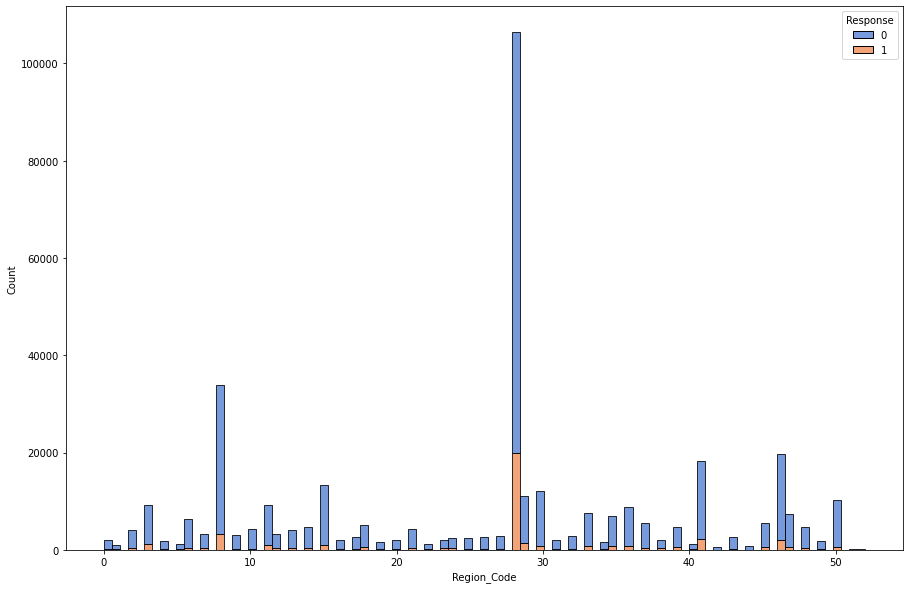

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(x='Region_Code', hue='Response', data=dataset, palette="muted", multiple="stack");

Rimane da analizzare la correlazione che vi è tra il canale di vendita (Policy_Sales_Channel) e  la feature (Previously_Insured): in questo caso sembra che vengano preferiti dei canali di vendita differenti rispetto alla condizione assicurativa del cliente.


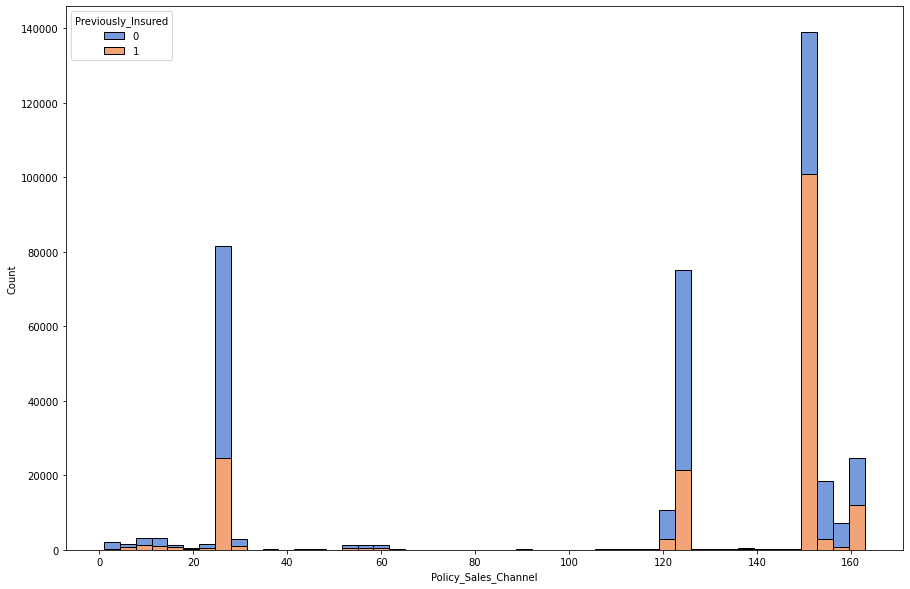

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(x='Policy_Sales_Channel', hue='Previously_Insured', data=dataset, palette="muted", multiple="stack");

Osservando l'efficacia dei canali di vendita principali, vediamo che hanno un tasso di "successo" differente.

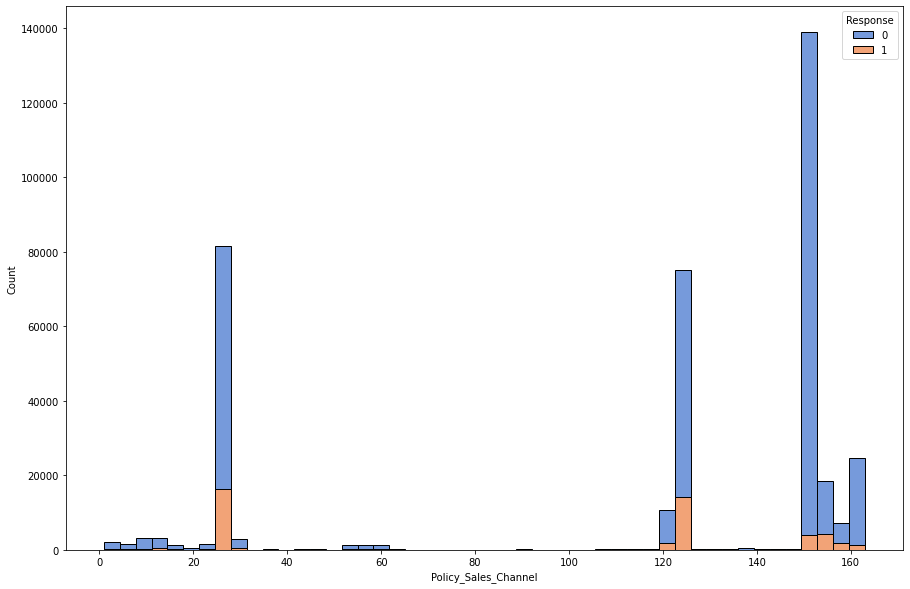

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(x='Policy_Sales_Channel', hue='Response', data=dataset, palette="muted", multiple="stack");

Vi è un piccolissimo numero di clienti che ha aderito ma che non ha la patente di guida:

In [ ]:
print(f"Corrisponde al {len(dataset[(dataset.Driving_License == 0) & (dataset.Response == 1)])/len(dataset[dataset.Response == 1])*100}% del totale dei clienti che ha aderito")

Corrisponde al 0.08777563690858488% del totale dei clienti che ha aderito


Visualizzando le informazioni di queste persone notiamo che sono di mezza età, tutti non erano precedentemente assicurati e avevano subito un danneggiamento al veicolo.

In [ ]:
dataset[(dataset.Driving_License == 0) & (dataset.Response == 1)]

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
9258,Female,53,0,8.0,0,1-2 Year,Yes,39478.0,25.0,234,1
20931,Female,44,0,3.0,0,1-2 Year,Yes,35644.0,26.0,272,1
26168,Male,63,0,28.0,0,1-2 Year,Yes,2630.0,122.0,44,1
30955,Male,45,0,28.0,0,1-2 Year,Yes,51397.0,124.0,43,1
35297,Female,67,0,28.0,0,1-2 Year,Yes,56891.0,26.0,42,1
45455,Male,61,0,8.0,0,1-2 Year,Yes,2630.0,26.0,76,1
46301,Female,69,0,28.0,0,1-2 Year,Yes,31145.0,122.0,82,1
48343,Male,55,0,29.0,0,1-2 Year,Yes,2630.0,26.0,232,1
53513,Male,59,0,8.0,0,1-2 Year,Yes,47979.0,26.0,212,1


## Feature Engineering

In [ ]:
dataset.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Decido di eliminare le features *Region_Code* e *Policy_Sales_Channel*  in quanto influenzano in maniera non significativa l'adesione da parte dei clienti e comporterebbero la creazione di numerose variabili binarie.

In [ ]:
dataset = dataset.drop(["Region_Code", "Policy_Sales_Channel"], axis=1)

Adesso andremo a trasformare le feature categoriche in feature binarie:

In [ ]:
categorical_features = ["Gender", "Vehicle_Age"]
dataset = pd.get_dummies(dataset, columns=categorical_features, prefix=categorical_features)

La feature *Vehicle_Damage* viene modificata in una variabile binaria: 1 se c'è stato un incidente pregresso, altrimenti 0.

In [ ]:
dataset["Vehicle_Damage"] = np.where(dataset["Vehicle_Damage"] == "Yes", 1, 0)

Il dataset risulta essere:

In [ ]:
dataset.head()

,Age,Driving_License,Previously_Insured,Vehicle_Damage,Annual_Premium,Vintage,Response,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
id,,,,,,,,,,,,
1,44,1,0,1,40454.0,217,1,0,1,0,0,1
2,76,1,0,0,33536.0,183,0,0,1,1,0,0
3,47,1,0,1,38294.0,27,1,0,1,0,0,1
4,21,1,1,0,28619.0,203,0,0,1,0,1,0
5,29,1,1,0,27496.0,39,0,1,0,0,1,0


Adesso effettueremo un'operazione di undersampling per bilanciare le classi:

In [ ]:
y = dataset["Response"]
X = dataset.drop("Response", axis=1)

rum = RandomUnderSampler(random_state=42)

X_r, y_r = rum.fit_resample(X,y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


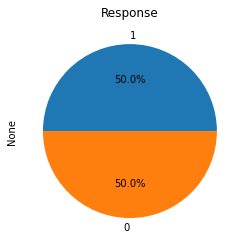

In [ ]:
pd.value_counts(y_r).plot.pie(autopct="%.1f%%", title="Response");

Ora effetuiamo la suddivisione del dataset:

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_r,y_r, test_size = 1/3,random_state = 42)
print(f"X_train:{len(X_train)}, y_train:{len(y_train)}, X_val:{len(X_val)}, y_val:{len(y_val)}") 

X_train:62280, y_train:62280, X_val:31140, y_val:31140


## Generazione e Valutazione dei modelli di learning 

Definisco una funzione che calcola l'intervallo di accuratezza con confidenza al 95%.

In [ ]:
def accuracy_interval(f):
  N = len(y_val)
  n_min = f + ( 1.96**2/(2*N) - 1.96 * np.sqrt( (f/N) - (f**2/N) + (1.96**2/(4*N**2) ) ) ) 
  n_max = f + ( 1.96**2/(2*N) + 1.96 * np.sqrt( (f/N) - (f**2/N) + (1.96**2/(4*N**2) ) ) ) 
  d = 1 + (1.96**2 / N)
  e_min = n_min / d
  e_max = n_max / d
  return e_min, e_max

e un dataframe dove salvare i valori delle performance dei modelli che verranno testati.

In [ ]:
performance = pd.DataFrame({}, columns=["model", "accuracy_interval", "mse"])

### Perceptron

#### Perceptron senza standardizzazione

In [ ]:
model = Perceptron(random_state=42)
model.fit(X_train, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=42, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
print('Accuracy on train {:.2f}%'.format(model.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(model.score(X_val, y_val)*100))

Accuracy on train 49.91%
Accuracy on val 50.15%


In [ ]:
y_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index = model.classes_, columns = model.classes_)

,0,1
0,15609,8
1,15515,8


In [ ]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.5015100886775479, recall: 0.9994877377217135, f1-score: 0.3344614757786933


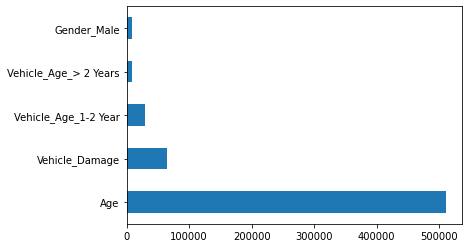

In [ ]:
coef = pd.Series(model.coef_[0], index=X.columns)
coef.nlargest().plot(kind='barh')

In [ ]:
performance.loc[0] = ["Perceptron senza standardizzazione", accuracy_interval(f1), mean_squared_error(y_val, y_pred)]
performance

,model,accuracy_interval,mse
0,Perceptron senza standardizzazione,"(0.32924187518956094, 0.33972191479763886)",0.498491


#### Perceptron con standardizzazione

In [ ]:
model = Pipeline([
    ('std', StandardScaler()),
    ('perceptron', Perceptron(random_state=42))
])

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('perceptron',
                 Perceptron(alpha=0.0001, class_weight=None,
                            early_stopping=False, eta0=1.0, fit_intercept=True,
                            max_iter=1000, n_iter_no_change=5, n_jobs=None,
                            penalty=None, random_state=42, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False))],
         verbose=False)

In [ ]:
print('Accuracy on train {:.2f}%'.format(model.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(model.score(X_val, y_val)*100))

Accuracy on train 69.51%
Accuracy on val 69.83%


In [ ]:
y_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index = model.classes_, columns = model.classes_)

,0,1
0,11444,4173
1,5221,10302


In [ ]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.6867086708670868, recall: 0.7327911890888135, f1-score: 0.6979238551471241


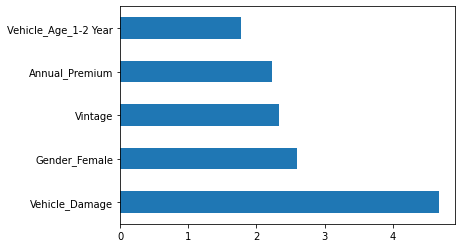

In [ ]:
coef = pd.Series(model[1].coef_[0], index=X.columns)
coef.nlargest().plot(kind='barh')

In [ ]:
performance.loc[1] = ["Perceptron con standardizzazione", accuracy_interval(f1), mean_squared_error(y_val, y_pred)]
performance

,model,accuracy_interval,mse
0,Perceptron senza standardizzazione,"(0.32924187518956094, 0.33972191479763886)",0.498491
1,Perceptron con standardizzazione,"(0.6927998284964185, 0.7029990538920304)",0.301670


#### Perceptron con Grid Search e CrossValidation

In [ ]:
model = Pipeline([
    ('std', StandardScaler()),
    ('perceptron', Perceptron(random_state=42))
])

grid = {
    'perceptron__penalty': ["l1", "l2", "elasticnet"],
    'perceptron__alpha': [0.0001, 0.001, 0.01, 1]
}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=skf)

gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('std',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('perceptron',
                                        Perceptron(alpha=0.0001,
                                                   class_weight=None,
                                                   early_stopping=False,
                                                   eta0=1.0, fit_intercept=True,
                                                   max_iter=1000,
                                                   n_iter_no_change=5,
                                                   n_jobs=None, penalty=None,
                                   

In [ ]:
print('Accuracy on train {:.2f}%'.format(gs.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs.score(X_val, y_val)*100))
print('Best parameters:', gs.best_params_)  
print('Best score: {:.4f}%'.format(round(gs.best_score_ * 100, 4)))

Accuracy on train 49.92%
Accuracy on val 50.15%
Best parameters: {'perceptron__alpha': 0.001, 'perceptron__penalty': 'l1'}
Best score: 77.8789%


In [ ]:
y_pred = gs.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=gs.best_estimator_.classes_, columns=gs.best_estimator_.classes_)

,0,1
0,15617,0
1,15523,0


In [ ]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.5015093127809891, recall: 1.0, f1-score: 0.3340034647218598


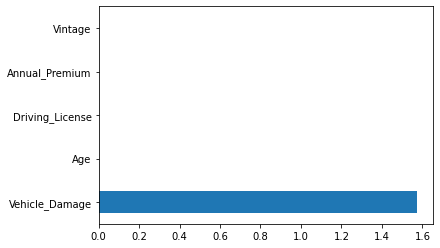

In [ ]:
coef = pd.Series(gs.best_estimator_[1].coef_[0], index=X.columns)
coef.nlargest().plot(kind='barh')

In [ ]:
performance.loc[2] = ["Perceptron con Grid Search", accuracy_interval(f1), mean_squared_error(y_val, y_pred)]
performance

,model,accuracy_interval,mse
0,Perceptron senza standardizzazione,"(0.32924187518956094, 0.33972191479763886)",0.498491
1,Perceptron con standardizzazione,"(0.6927998284964185, 0.7029990538920304)",0.301670
2,Perceptron con Grid Search,"(0.32878570795115136, 0.3392621729139192)",0.498491


#### Perceptron con feature polinomiali

In [ ]:
model = Pipeline([
    ('std', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3)),
    ('perceptron', Perceptron())
])

grid = {
    'perceptron__penalty': ["l1", "l2", "elasticnet"],
    'perceptron__alpha': [0.0001, 0.001, 0.01, 1]
}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=skf)

gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('std',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('poly',
                                        PolynomialFeatures(degree=3,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('perceptron',
                                        Perceptron(alpha=0.0001,
                                                   class_weight=None,
                                                   ear

In [ ]:
print('Accuracy on train {:.2f}%'.format(gs.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs.score(X_val, y_val)*100))
print('Best parameters:', gs.best_params_)  
print('Best score: {:.4f}%'.format(round(gs.best_score_ * 100, 4)))

Accuracy on train 73.73%
Accuracy on val 73.75%
Best parameters: {'perceptron__alpha': 0.001, 'perceptron__penalty': 'l2'}
Best score: 74.5713%


In [ ]:
y_pred = gs.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index = gs.best_estimator_.classes_, columns = gs.best_estimator_.classes_)

,0,1
0,10663,4954
1,3220,12303


In [ ]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.7680616581430526, recall: 0.6827815841710956, f1-score: 0.73677794438527


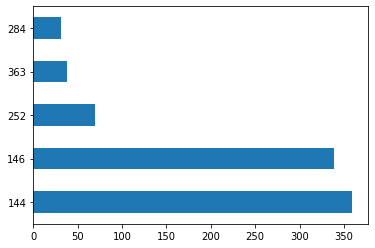

In [ ]:
pc_imp = pd.Series(gs.best_estimator_[2].coef_[0])
pc_imp.nlargest().plot(kind='barh')

In [ ]:
performance.loc[3] = ["Perceptron con PolynomialFeatures", accuracy_interval(f1), mean_squared_error(y_val, y_pred)]
performance

,model,accuracy_interval,mse
0,Perceptron senza standardizzazione,"(0.32924187518956094, 0.33972191479763886)",0.498491
1,Perceptron con standardizzazione,"(0.6927998284964185, 0.7029990538920304)",0.301670
2,Perceptron con Grid Search,"(0.32878570795115136, 0.3392621729139192)",0.498491
3,Perceptron con PolynomialFeatures,"(0.7318576307013072, 0.7416398448418068)",0.262492


### Logistic Regression

#### Logistic Regression senza standardizzazione

In [ ]:
model = LogisticRegression(random_state=42, solver="saga")
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print('Accuracy on train {:.2f}%'.format(model.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(model.score(X_val, y_val)*100))

Accuracy on train 49.72%
Accuracy on val 49.73%


In [ ]:
y_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index = model.classes_, columns = model.classes_)

,0,1
0,1907,13710
1,1944,13579


In [ ]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.4951960529732537, recall: 0.1221105205865403, f1-score: 0.41513304636777504


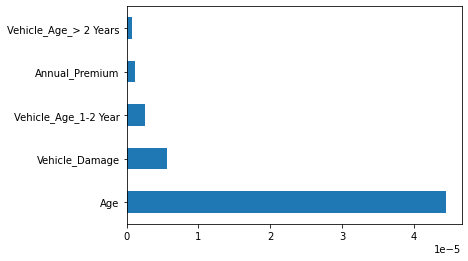

In [ ]:
coef = pd.Series(model.coef_[0], index=X.columns)
coef.nlargest().plot(kind='barh')

In [ ]:
performance.loc[4] = ["Logistic Regression senza standardizzazione", accuracy_interval(f1), mean_squared_error(y_val, y_pred)]
performance

,model,accuracy_interval,mse
0,Perceptron senza standardizzazione,"(0.32924187518956094, 0.33972191479763886)",0.498491
1,Perceptron con standardizzazione,"(0.6927998284964185, 0.7029990538920304)",0.301670
2,Perceptron con Grid Search,"(0.32878570795115136, 0.3392621729139192)",0.498491
3,Perceptron con PolynomialFeatures,"(0.7318576307013072, 0.7416398448418068)",0.262492
4,Logistic Regression senza standardizzazione,"(0.4096709240029316, 0.4206161054489851)",0.502697


#### Logistic Regression con standardizzazione

In [ ]:
model = Pipeline([
    ('std', StandardScaler()),
    ('lr', LogisticRegression(random_state=42, solver="saga"))
])

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
print('Accuracy on train {:.2f}%'.format(model.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(model.score(X_val, y_val)*100))

Accuracy on train 78.29%
Accuracy on val 78.46%


In [ ]:
y_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index = model.classes_, columns = model.classes_)

,0,1
0,9325,6292
1,414,15109


In [ ]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.9574905021049389, recall: 0.5971057181276813, f1-score: 0.7769549076464758


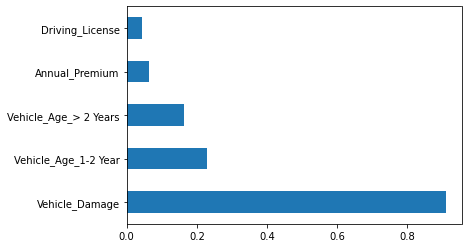

In [ ]:
coef = pd.Series(model[1].coef_[0], index=X.columns)
coef.nlargest().plot(kind='barh')

In [ ]:
performance.loc[5] = ["Logistic Regression con standardizzazione", accuracy_interval(f1), mean_squared_error(y_val, y_pred)]
performance

,model,accuracy_interval,mse
0,Perceptron senza standardizzazione,"(0.32924187518956094, 0.33972191479763886)",0.498491
1,Perceptron con standardizzazione,"(0.6927998284964185, 0.7029990538920304)",0.301670
2,Perceptron con Grid Search,"(0.32878570795115136, 0.3392621729139192)",0.498491
3,Perceptron con PolynomialFeatures,"(0.7318576307013072, 0.7416398448418068)",0.262492
4,Logistic Regression senza standardizzazione,"(0.4096709240029316, 0.4206161054489851)",0.502697
5,Logistic Regression con standardizzazione,"(0.7722971896562784, 0.7815443007339923)",0.215350


#### Logistic Regression con Grid Search e CrossValidation

In [ ]:
model = Pipeline([
    ('std', StandardScaler()),
    ('lr', LogisticRegression(random_state=42, solver="saga"))
])

grid = {
    'lr__penalty': ["l1", "l2", "elasticnet"],
    'lr__C': [0.1, 1, 10],
    'lr__l1_ratio': [0.2, 0.5]
}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=skf)

gs.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (p

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('std',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('lr',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                          

In [ ]:
print('Accuracy on train {:.2f}%'.format(gs.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs.score(X_val, y_val)*100))
print('Best parameters:', gs.best_params_)  
print('Best score: {:.4f}%'.format(round(gs.best_score_ * 100, 4)))

Accuracy on train 78.30%
Accuracy on val 78.47%
Best parameters: {'lr__C': 0.1, 'lr__l1_ratio': 0.5, 'lr__penalty': 'elasticnet'}
Best score: 78.2964%


In [ ]:
y_pred = gs.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=gs.best_estimator_.classes_, columns=gs.best_estimator_.classes_)

,0,1
0,9325,6292
1,413,15110


In [ ]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.9575888272745944, recall: 0.5971057181276813, f1-score: 0.7769854124245463


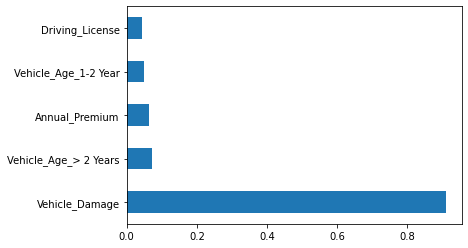

In [ ]:
coef = pd.Series(gs.best_estimator_[1].coef_[0], index=X.columns)
coef.nlargest().plot(kind='barh')

In [ ]:
performance.loc[6] = ["Logistic Regression con Grid Search", accuracy_interval(f1), mean_squared_error(y_val, y_pred)]
performance

,model,accuracy_interval,mse
0,Perceptron senza standardizzazione,"(0.32924187518956094, 0.33972191479763886)",0.498491
1,Perceptron con standardizzazione,"(0.6927998284964185, 0.7029990538920304)",0.301670
2,Perceptron con Grid Search,"(0.32878570795115136, 0.3392621729139192)",0.498491
3,Perceptron con PolynomialFeatures,"(0.7318576307013072, 0.7416398448418068)",0.262492
4,Logistic Regression senza standardizzazione,"(0.4096709240029316, 0.4206161054489851)",0.502697
5,Logistic Regression con standardizzazione,"(0.7722971896562784, 0.7815443007339923)",0.215350
6,Logistic Regression con Grid Search,"(0.7723279160548838, 0.7815745763659852)",0.215318


#### Logistic Regression con PolynomialFeatures

In [ ]:
model = Pipeline([
    ('std', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3)),
    ('lr', LogisticRegression(random_state=42, solver="saga"))
])

grid = {
    'lr__penalty': ["l1", "l2", "elasticnet"],
    'lr__C': [0.1, 1, 10],
    'lr__l1_ratio': [0.2, 0.5]
}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=skf)

gs.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (pen

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('std',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('poly',
                                        PolynomialFeatures(degree=3,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('lr',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                     

In [ ]:
print('Accuracy on train {:.2f}%'.format(gs.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs.score(X_val, y_val)*100))
print('Best parameters:', gs.best_params_)  
print('Best score: {:.4f}%'.format(round(gs.best_score_ * 100, 4)))

Accuracy on train 76.82%
Accuracy on val 76.75%
Best parameters: {'lr__C': 0.1, 'lr__l1_ratio': 0.2, 'lr__penalty': 'l1'}
Best score: 76.8176%


In [ ]:
y_pred = gs.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=gs.best_estimator_.classes_, columns=gs.best_estimator_.classes_)

,0,1
0,11019,4598
1,2641,12882


In [ ]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.8066617862371889, recall: 0.7055772555548441, f1-score: 0.7666986817535772


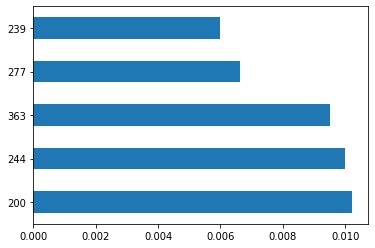

In [ ]:
coef = pd.Series(gs.best_estimator_[2].coef_[0])
coef.nlargest().plot(kind='barh')

In [ ]:
performance.loc[7] = ["Logistic Regression con PolynomialFeatures", accuracy_interval(f1), mean_squared_error(y_val, y_pred)]
performance

,model,accuracy_interval,mse
0,Perceptron senza standardizzazione,"(0.32924187518956094, 0.33972191479763886)",0.498491
1,Perceptron con standardizzazione,"(0.6927998284964185, 0.7029990538920304)",0.301670
2,Perceptron con Grid Search,"(0.32878570795115136, 0.3392621729139192)",0.498491
3,Perceptron con PolynomialFeatures,"(0.7318576307013072, 0.7416398448418068)",0.262492
4,Logistic Regression senza standardizzazione,"(0.4096709240029316, 0.4206161054489851)",0.502697
5,Logistic Regression con standardizzazione,"(0.7722971896562784, 0.7815443007339923)",0.215350
6,Logistic Regression con Grid Search,"(0.7723279160548838, 0.7815745763659852)",0.215318
7,Logistic Regression con PolynomialFeatures,"(0.7619684488474691, 0.7713631199726341)",0.232466


### SVM

In [ ]:
model = Pipeline([
    ('std', StandardScaler()),
    ('svm', SVC())
])

grid = {
    'svm__kernel': ['rbf'],
    'svm__C': [0.01, 0.1, 1],
}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=skf)

gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('std',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svm',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, sh

In [ ]:
print('Accuracy on train {:.2f}%'.format(gs.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(gs.score(X_val, y_val)*100))
print('Best parameters:', gs.best_params_)  
print('Best score: {:.4f}%'.format(round(gs.best_score_ * 100, 4)))

Accuracy on train 79.14%
Accuracy on val 79.03%
Best parameters: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best score: 79.1105%


In [ ]:
y_pred = gs.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index = gs.classes_, columns = gs.classes_)

,0,1
0,10017,5600
1,931,14592


In [ ]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.9149616368286445, recall: 0.6414164051994621, f1-score: 0.7856429274576564


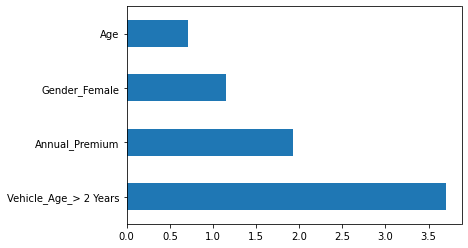

In [ ]:
coef = pd.Series(gs.best_estimator_[1].support_vectors_[0], index=X.columns)
coef.nlargest(4).plot(kind='barh')

In [ ]:
performance.loc[8] = ["SVM", accuracy_interval(f1), mean_squared_error(y_val, y_pred)]
performance

,model,accuracy_interval,mse
0,Perceptron senza standardizzazione,"(0.32924187518956094, 0.33972191479763886)",0.498491
1,Perceptron con standardizzazione,"(0.6927998284964185, 0.7029990538920304)",0.301670
2,Perceptron con Grid Search,"(0.32878570795115136, 0.3392621729139192)",0.498491
3,Perceptron con PolynomialFeatures,"(0.7318576307013072, 0.7416398448418068)",0.262492
4,Logistic Regression senza standardizzazione,"(0.4096709240029316, 0.4206161054489851)",0.502697
5,Logistic Regression con standardizzazione,"(0.7722971896562784, 0.7815443007339923)",0.215350
6,Logistic Regression con Grid Search,"(0.7723279160548838, 0.7815745763659852)",0.215318
7,Logistic Regression con PolynomialFeatures,"(0.7619684488474691, 0.7713631199726341)",0.232466
8,SVM,"(0.7810497967389304, 0.7901655899352312)",0.209730


### Decision Tree

In [ ]:
m_tree = Pipeline([
    ('std', StandardScaler()),
    ('dc', DecisionTreeClassifier(random_state=42))
])

num_features = X_train.shape[1]

grid = {
             'dc__min_samples_split': range(2, 4, 1),
             'dc__min_samples_leaf': range(1, 4, 1), 
             'dc__max_depth': [None] + [i for i in range(2, 7)],
             'dc__max_features': range(2, num_features, 1)}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
m_tree = GridSearchCV(m_tree, grid, cv=skf)

m_tree.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('std',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('dc',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                             

In [ ]:
print('Accuracy on train {:.2f}%'.format(m_tree.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(m_tree.score(X_val, y_val)*100))
print('Best parameters:', m_tree.best_params_)  
print('Best score: {:.4f}%'.format(round(m_tree.best_score_ * 100, 4)))

Accuracy on train 79.34%
Accuracy on val 79.34%
Best parameters: {'dc__max_depth': 6, 'dc__max_features': 9, 'dc__min_samples_leaf': 3, 'dc__min_samples_split': 2}
Best score: 79.2646%


In [ ]:
y_pred = m_tree.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index = m_tree.classes_, columns = m_tree.classes_)

,0,1
0,10238,5379
1,1053,14470


In [ ]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.9067398813214065, recall: 0.6555676506371262, f1-score: 0.7895622698935147


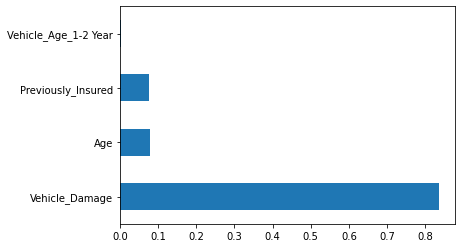

In [ ]:
coef = pd.Series(m_tree.best_estimator_[1].feature_importances_, index=X.columns)
coef.nlargest(4).plot(kind='barh')

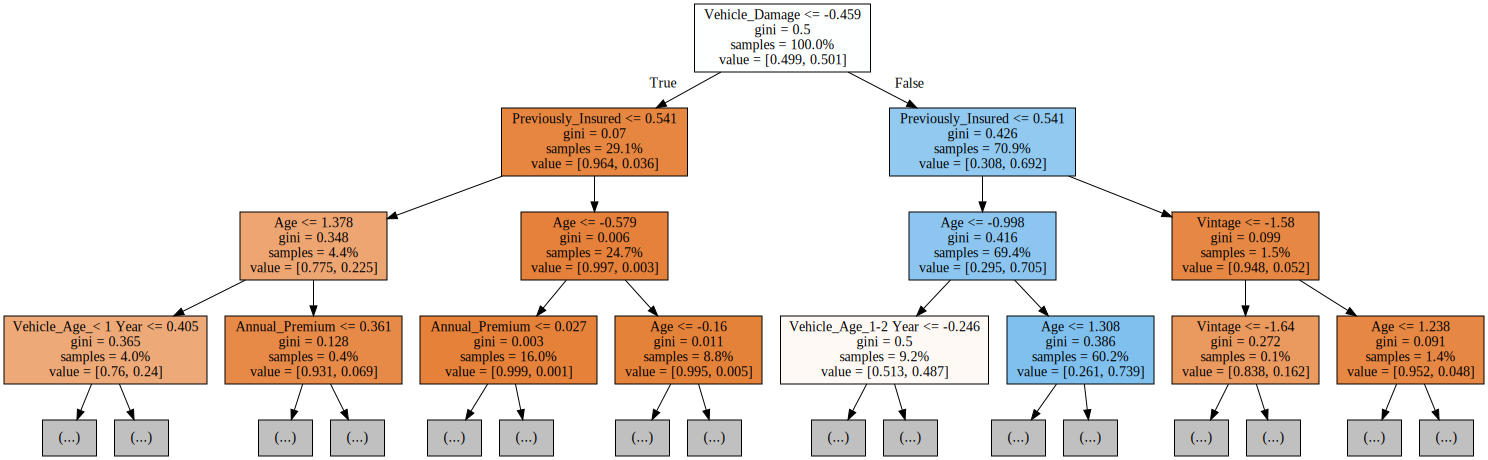

In [ ]:
dot_data = tree.export_graphviz(m_tree.best_estimator_[1], 
                                out_file=None, 
                                feature_names=X.columns,  
                                filled=True,
                                proportion=True,
                                max_depth=3)

graph = graphviz.Source(dot_data, format="png") 
graph

In [ ]:
m_tree.best_estimator_[1].get_n_leaves()

57

In [ ]:
m_tree.best_estimator_[1].get_depth()

6

In [ ]:
performance.loc[9] = ["Decision Tree", accuracy_interval(f1), mean_squared_error(y_val, y_pred)]
performance

,model,accuracy_interval,mse
0,Perceptron senza standardizzazione,"(0.32924187518956094, 0.33972191479763886)",0.498491
1,Perceptron con standardizzazione,"(0.6927998284964185, 0.7029990538920304)",0.301670
2,Perceptron con Grid Search,"(0.32878570795115136, 0.3392621729139192)",0.498491
3,Perceptron con PolynomialFeatures,"(0.7318576307013072, 0.7416398448418068)",0.262492
4,Logistic Regression senza standardizzazione,"(0.4096709240029316, 0.4206161054489851)",0.502697
5,Logistic Regression con standardizzazione,"(0.7722971896562784, 0.7815443007339923)",0.215350
6,Logistic Regression con Grid Search,"(0.7723279160548838, 0.7815745763659852)",0.215318
7,Logistic Regression con PolynomialFeatures,"(0.7619684488474691, 0.7713631199726341)",0.232466
8,SVM,"(0.7810497967389304, 0.7901655899352312)",0.209730
9,Decision Tree,"(0.784999260446297, 0.7940538441960057)",0.206551


### XGBoost

In [ ]:
xgb = Pipeline([
    ('std', StandardScaler()),
    ('xgb', XGBClassifier(nthread=8, objective='binary:logistic'))
])

grid = {
    'xgb__eta': [0.002, 0.1, 0.5],
    'xgb__max_depth': [6],
    'xgb__n_estimators': [150, 300],
    'xgb__alpha': [0.0001, 0.001]
}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
xgb = GridSearchCV(xgb, grid, cv=skf)

xgb.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('std',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                             

In [ ]:
print('Accuracy on train {:.2f}%'.format(xgb.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(xgb.score(X_val, y_val)*100))
print('Best parameters:', xgb.best_params_)  
print('Best score: {:.4f}%'.format(round(xgb.best_score_ * 100, 4)))

Accuracy on train 80.31%
Accuracy on val 79.31%
Best parameters: {'xgb__alpha': 0.0001, 'xgb__eta': 0.002, 'xgb__max_depth': 6, 'xgb__n_estimators': 150}
Best score: 79.1458%


In [ ]:
y_pred = xgb.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index = xgb.classes_, columns = xgb.classes_)

,0,1
0,10346,5271
1,1173,14350


In [ ]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.8981682437711607, recall: 0.6624831913939937, f1-score: 0.7895847951984074


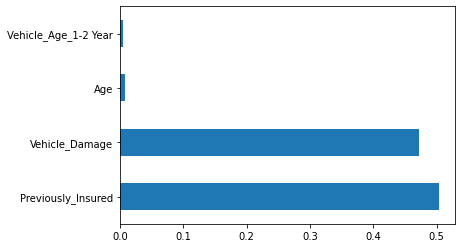

In [ ]:
coef = pd.Series(xgb.best_estimator_[1].feature_importances_, index=X.columns)
coef.nlargest(4).plot(kind='barh')

In [ ]:
performance.loc[10] = ["XGBoost", accuracy_interval(f1), mean_squared_error(y_val, y_pred)]
performance

,model,accuracy_interval,mse
0,Perceptron senza standardizzazione,"(0.32924187518956094, 0.33972191479763886)",0.498491
1,Perceptron con standardizzazione,"(0.6927998284964185, 0.7029990538920304)",0.301670
2,Perceptron con Grid Search,"(0.32878570795115136, 0.3392621729139192)",0.498491
3,Perceptron con PolynomialFeatures,"(0.7318576307013072, 0.7416398448418068)",0.262492
4,Logistic Regression senza standardizzazione,"(0.4096709240029316, 0.4206161054489851)",0.502697
5,Logistic Regression con standardizzazione,"(0.7722971896562784, 0.7815443007339923)",0.215350
6,Logistic Regression con Grid Search,"(0.7723279160548838, 0.7815745763659852)",0.215318
7,Logistic Regression con PolynomialFeatures,"(0.7619684488474691, 0.7713631199726341)",0.232466
8,SVM,"(0.7810497967389304, 0.7901655899352312)",0.209730
9,Decision Tree,"(0.784999260446297, 0.7940538441960057)",0.206551


### Modello casuale

In [ ]:
random = DummyClassifier(strategy="uniform", random_state=42)
random.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=42, strategy='uniform')

In [ ]:
print('Accuracy on train {:.2f}%'.format(random.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(random.score(X_val, y_val)*100))

Accuracy on train 49.96%
Accuracy on val 50.64%


In [ ]:
y_pred = random.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index = random.classes_, columns = random.classes_)

,0,1
0,7907,7710
1,7661,7862


In [ ]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.5079008221993834, recall: 0.5063072293014024, f1-score: 0.5063894637459521


In [ ]:
performance.loc[11] = ["Modello casuale", accuracy_interval(f1), mean_squared_error(y_val, y_pred)]
performance

,model,accuracy_interval,mse
0,Perceptron senza standardizzazione,"(0.32924187518956094, 0.33972191479763886)",0.498491
1,Perceptron con standardizzazione,"(0.6927998284964185, 0.7029990538920304)",0.301670
2,Perceptron con Grid Search,"(0.32878570795115136, 0.3392621729139192)",0.498491
3,Perceptron con PolynomialFeatures,"(0.7318576307013072, 0.7416398448418068)",0.262492
4,Logistic Regression senza standardizzazione,"(0.4096709240029316, 0.4206161054489851)",0.502697
5,Logistic Regression con standardizzazione,"(0.7722971896562784, 0.7815443007339923)",0.215350
6,Logistic Regression con Grid Search,"(0.7723279160548838, 0.7815745763659852)",0.215318
7,Logistic Regression con PolynomialFeatures,"(0.7619684488474691, 0.7713631199726341)",0.232466
8,SVM,"(0.7810497967389304, 0.7901655899352312)",0.209730
9,Decision Tree,"(0.784999260446297, 0.7940538441960057)",0.206551


## Confronto fra modelli

In [ ]:
# salvo i valori delle performance in un file csv
performance.to_csv("/content/performance.csv")

Visualizziamo le accuratezze e i valori MSE di tutti i modelli testati:

In [ ]:
performance = pd.read_csv("/content/performance.csv", usecols=["model", "accuracy_interval", "mse"])
performance

,model,accuracy_interval,mse
0,Perceptron senza standardizzazione,"(0.32924187518956094, 0.33972191479763886)",0.498491
1,Perceptron con standardizzazione,"(0.6927998284964185, 0.7029990538920304)",0.301670
2,Perceptron con Grid Search,"(0.32878570795115136, 0.3392621729139192)",0.498491
3,Perceptron con PolynomialFeatures,"(0.7318576307013072, 0.7416398448418068)",0.262492
4,Logistic Regression senza standardizzazione,"(0.4096709240029316, 0.4206161054489851)",0.502697
5,Logistic Regression con standardizzazione,"(0.7722971896562784, 0.7815443007339923)",0.215350
6,Logistic Regression con Grid Search,"(0.7723279160548838, 0.7815745763659852)",0.215318
7,Logistic Regression con PolynomialFeatures,"(0.7619684488474691, 0.7713631199726341)",0.232466
8,SVM,"(0.7810497967389304, 0.7901655899352312)",0.209730
9,Decision Tree,"(0.784999260446297, 0.7940538441960057)",0.206551


Di seguito effettuiamo un confronto fra i modelli che hanno ottenuto performance migliori, impostando un confidenza del 95%.

Tra questi troviamo:
- Perceptron con PolynomialFeatures
- Logistic Regression con Grid Search 
  - si potrebbe prendere in considerazione anche il modello non lineare che è quasi equivalente.
- SVM con kernel RBF
- Decision Tree
- XGBoost

In [ ]:
def model_comparison(mse_1, mse_2):
    d = np.abs(mse_1 - mse_2)
    variance = (mse_1 * (1 - mse_1)) / len(X_val) + (mse_2 * (1 - mse_2)) / len(X_val)
    d_min = d - 1.96 * np.sqrt(variance)
    d_max = d + 1.96 * np.sqrt(variance)
    return (d_min, d_max)

In [ ]:
best_models = [
  ('Perceptron', performance.iloc[3]["mse"]),
  ('Logistic Regression', performance.iloc[6]["mse"]),
  ('SVM', performance.iloc[8]["mse"]),
  ('Decision Tree', performance.iloc[9]["mse"]),
  ('XGBoost', performance.iloc[10]["mse"])
]

In [ ]:
from itertools import combinations

for model1, model2 in list(combinations(best_models, 2)):
  interval = model_comparison(model1[1], model2[1])
  models = model1[0] + " vs " + model2[0]
  print(f"{models:<40}  {np.round(interval, 4)}")

Perceptron vs Logistic Regression         [0.0405 0.0539]
Perceptron vs SVM                         [0.0461 0.0594]
Perceptron vs Decision Tree               [0.0493 0.0626]
Perceptron vs XGBoost                     [0.0489 0.0622]
Logistic Regression vs SVM                [-0.0008  0.012 ]
Logistic Regression vs Decision Tree      [0.0024 0.0152]
Logistic Regression vs XGBoost            [0.002  0.0148]
SVM vs Decision Tree                      [-0.0032  0.0096]
SVM vs XGBoost                            [-0.0036  0.0092]
Decision Tree vs XGBoost                  [-0.006   0.0067]


Notiamo che tra i modelli non lineari la differenza non è statisticamente significativa, quindi sono equiparabili.

Sarebbe interessante testare queste differenze addestrando i modelli sul dataset bilanciato con un'operazione di oversampling: ciò richiederebbe numerose ore di addestramento e importanti risorse hardware visto il grande numero di record presenti nel dataset originale (380k). 

Adesso effettuiamo il confronto di tutti i modelli testati con un **modello casuale**:

In [ ]:
def random_comparision(mse1, mse2):
  d = np.abs(mse1 - mse2)
  variance = (mse1 * (1 - mse1)) / len(X_val) + (mse2 * (1 - mse2)) / len(X_val)
  d_min = d - 2.58 * np.sqrt(variance)
  d_max = d + 2.58 * np.sqrt(variance)
  return (d_min, d_max)

In [ ]:
mse_random = performance.iloc[11]["mse"]

In [ ]:
for model, _ , mse in performance.values:
  if model != "Modello casuale":
    interval = random_comparision(mse, mse_random)
    print(f"Modello casuale vs {model:<50}  {np.round(interval, 4)}")

Modello casuale vs Perceptron senza standardizzazione                  [-0.0055  0.0152]
Modello casuale vs Perceptron con standardizzazione                    [0.182  0.2019]
Modello casuale vs Perceptron con Grid Search                          [-0.0055  0.0152]
Modello casuale vs Perceptron con PolynomialFeatures                   [0.2214 0.2409]
Modello casuale vs Logistic Regression senza standardizzazione         [-0.0012  0.0194]
Modello casuale vs Logistic Regression con standardizzazione           [0.2688 0.2877]
Modello casuale vs Logistic Regression con Grid Search                 [0.2688 0.2878]
Modello casuale vs Logistic Regression con PolynomialFeatures          [0.2516 0.2707]
Modello casuale vs SVM                                                 [0.2745 0.2933]
Modello casuale vs Decision Tree                                       [0.2777 0.2965]
Modello casuale vs XGBoost                                             [0.2773 0.2961]


Dai precedenti risultati notiamo che i seguenti modelli sono statisticamente equivalenti, con confidenza del 99%, ad un modello casuale:
- Perceptron senza standardizzazione
- Perceptron con regolarizzazione (Grid Search)
- Logistic Regression senza standardizzazione

### Modello migliore

Abbiamo visto che i modelli più promettenti si equivalgono statisticamente.

Di seguito si vuole effettuare un test su XGBoost, ovvero il modello che sembra aver avuto in assoluto i risultati migliori.
<br>
Inizialmente abbiamo potuto osservare che le nostre feature avevano un grado di correlazione basso: un modello non lineare come XGBoost ha ottenuto un buon margine fra le istanze delle due classi.

Questa volta effettuiamo un'operazione di oversampling sul dataset per verificare se possiamo ottenere miglioramenti sul valore dell'accuratezza del modello.

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_r_2, y_r_2 = sm.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(X.shape, X_r_2.shape)

(381109, 11) (668798, 11)


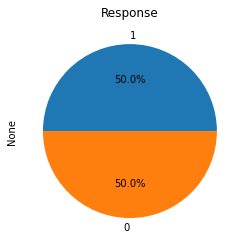

In [ ]:
pd.value_counts(y_r_2).plot.pie(autopct="%.1f%%", title="Response");

In [ ]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_r_2, y_r_2, test_size = 1/3,random_state = 42)
print(f"X_train:{len(X_train2)}, y_train:{len(y_train2)}, X_val:{len(X_val2)}, y_val:{len(y_val2)}") 

X_train:445865, y_train:445865, X_val:222933, y_val:222933


In [ ]:
xgb = Pipeline([
    ('std', StandardScaler()),
    ('xgb', XGBClassifier(nthread=8, objective='binary:logistic'))
])

grid = {
    'xgb__eta': [0.002, 0.1, 0.5],
    'xgb__max_depth': [6],
    'xgb__n_estimators': [150, 300],
    'xgb__alpha': [0.0001, 0.001]
}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
xgb = GridSearchCV(xgb, grid, cv=skf)

xgb.fit(X_train2, y_train2)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('std',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                             

In [ ]:
print('Accuracy on train {:.2f}%'.format(xgb.score(X_train2, y_train2)*100))
print('Accuracy on val {:.2f}%'.format(xgb.score(X_val2, y_val2)*100))
print('Best parameters:', xgb.best_params_)  
print('Best score: {:.4f}%'.format(round(xgb.best_score_ * 100, 4)))

Accuracy on train 91.56%
Accuracy on val 91.33%
Best parameters: {'xgb__alpha': 0.0001, 'xgb__eta': 0.002, 'xgb__max_depth': 6, 'xgb__n_estimators': 300}
Best score: 91.2590%


In [ ]:
y_pred = xgb.predict(X_val2)
cm = confusion_matrix(y_val2, y_pred)
pd.DataFrame(cm, index = xgb.classes_, columns = xgb.classes_)

,0,1
0,108316,2960
1,16363,95294


In [ ]:
precision = precision_score(y_val2, y_pred, pos_label=0)
recall = recall_score(y_val2, y_pred, pos_label=0)
f1 = f1_score(y_val2, y_pred, average="macro")

print(f"precision: {precision}, recall: {recall}, f1-score: {f1}")

precision: 0.8687589730427738, recall: 0.9733994751788346, f1-score: 0.9130269837185047


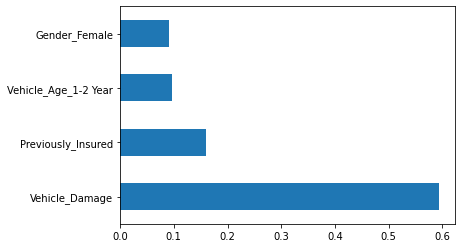

In [ ]:
coef = pd.Series(xgb.best_estimator_[1].feature_importances_, index=X.columns)
coef.nlargest(4).plot(kind='barh')

In [ ]:
print(f"Accuracy interval: {accuracy_interval(f1)} MSE: {mean_squared_error(y_val2, y_pred)}")

Accuracy interval: (0.9098459124246795, 0.9161061610661022) MSE: 0.08667626596331633


Precedentemente il modello aveva ottenuto il seguente intervallo di accuratezza:(0.7850219606720868, 0.794076189022998).

C'è stato un miglioramento di 10-11 punti percentuali: è quindi verosimile che se avessimo effettuato un'operazione di oversampling sin dall'inizio avremmo ottenuto miglioramenti anche in altri modelli.